<ipython-input-13-14699e7b7612>:156: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  Y = np.zeros(shape=[len(labels)], dtype=np.int)


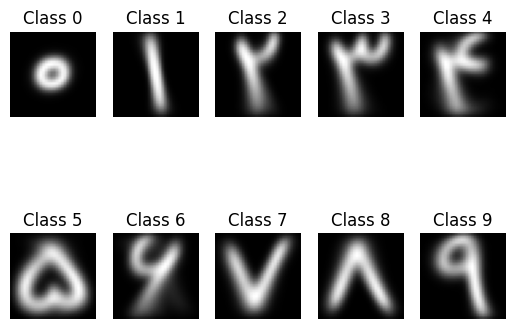

MDC Classifier Accuracy: 73.69%


ValueError: ignored

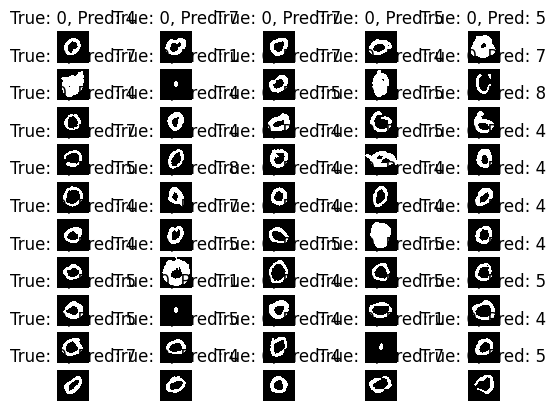

In [13]:
import matplotlib.pyplot as plt
# *-* coding: utf-8 *-*

# Hoda Dataset Reader
# Python code for reading Hoda farsi digit dataset.

# Hoda Farsi Digit Dataset:
# http://farsiocr.ir/
# http://farsiocr.ir/مجموعه-داده/مجموعه-ارقام-دستنویس-هدی
# http://dadegan.ir/catalog/hoda

# Repository:
# https://github.com/amir-saniyan/HodaDatasetReader

import struct
import numpy as np
import cv2


def __convert_to_one_hot(vector, num_classes):
    result = np.zeros(shape=[len(vector), num_classes])
    result[np.arange(len(vector)), vector] = 1
    return result


def __resize_image(src_image, dst_image_height, dst_image_width):
    src_image_height = src_image.shape[0]
    src_image_width = src_image.shape[1]

    if src_image_height > dst_image_height or src_image_width > dst_image_width:
        height_scale = dst_image_height / src_image_height
        width_scale = dst_image_width / src_image_width
        scale = min(height_scale, width_scale)
        img = cv2.resize(src=src_image, dsize=(0, 0), fx=scale, fy=scale, interpolation=cv2.INTER_CUBIC)
    else:
        img = src_image

    img_height = img.shape[0]
    img_width = img.shape[1]

    dst_image = np.zeros(shape=[dst_image_height, dst_image_width], dtype=np.uint8)

    y_offset = (dst_image_height - img_height) // 2
    x_offset = (dst_image_width - img_width) // 2

    dst_image[y_offset:y_offset+img_height, x_offset:x_offset+img_width] = img

    return dst_image


def read_hoda_cdb(file_name):
    with open(file_name, 'rb') as binary_file:

        data = binary_file.read()

        offset = 0

        # read private header

        yy = struct.unpack_from('H', data, offset)[0]
        offset += 2

        m = struct.unpack_from('B', data, offset)[0]
        offset += 1

        d = struct.unpack_from('B', data, offset)[0]
        offset += 1

        H = struct.unpack_from('B', data, offset)[0]
        offset += 1

        W = struct.unpack_from('B', data, offset)[0]
        offset += 1

        TotalRec = struct.unpack_from('I', data, offset)[0]
        offset += 4

        LetterCount = struct.unpack_from('128I', data, offset)
        offset += 128 * 4

        imgType = struct.unpack_from('B', data, offset)[0]  # 0: binary, 1: gray
        offset += 1

        Comments = struct.unpack_from('256c', data, offset)
        offset += 256 * 1

        Reserved = struct.unpack_from('245c', data, offset)
        offset += 245 * 1

        if (W > 0) and (H > 0):
            normal = True
        else:
            normal = False

        images = []
        labels = []

        for i in range(TotalRec):

            StartByte = struct.unpack_from('B', data, offset)[0]  # must be 0xff
            offset += 1

            label = struct.unpack_from('B', data, offset)[0]
            offset += 1

            if not normal:
                W = struct.unpack_from('B', data, offset)[0]
                offset += 1

                H = struct.unpack_from('B', data, offset)[0]
                offset += 1

            ByteCount = struct.unpack_from('H', data, offset)[0]
            offset += 2

            image = np.zeros(shape=[H, W], dtype=np.uint8)

            if imgType == 0:
                # Binary
                for y in range(H):
                    bWhite = True
                    counter = 0
                    while counter < W:
                        WBcount = struct.unpack_from('B', data, offset)[0]
                        offset += 1
                        # x = 0
                        # while x < WBcount:
                        #     if bWhite:
                        #         image[y, x + counter] = 0  # Background
                        #     else:
                        #         image[y, x + counter] = 255  # ForeGround
                        #     x += 1
                        if bWhite:
                            image[y, counter:counter + WBcount] = 0  # Background
                        else:
                            image[y, counter:counter + WBcount] = 255  # ForeGround
                        bWhite = not bWhite  # black white black white ...
                        counter += WBcount
            else:
                # GrayScale mode
                data = struct.unpack_from('{}B'.format(W * H), data, offset)
                offset += W * H
                image = np.asarray(data, dtype=np.uint8).reshape([W, H]).T

            images.append(image)
            labels.append(label)

        return images, labels


def read_hoda_dataset(dataset_path, images_height=32, images_width=32, one_hot=False, reshape=True):
    images, labels = read_hoda_cdb(dataset_path)
    assert len(images) == len(labels)

    X = np.zeros(shape=[len(images), images_height, images_width], dtype=np.float32)
    Y = np.zeros(shape=[len(labels)], dtype=np.int)

    for i in range(len(images)):
        image = images[i]
        # Image resizing.
        image = __resize_image(src_image=image, dst_image_height=images_height, dst_image_width=images_width)
        # Image normalization.
        image = image / 255
        # Image binarization.
        image = np.where(image >= 0.5, 1, 0)
        # Image.
        X[i] = image
        # Label.
        Y[i] = labels[i]

    if one_hot:
        Y = __convert_to_one_hot(Y, 10).astype(dtype=np.float32)
    else:
        Y = Y.astype(dtype=np.float32)

    if reshape:
        X = X.reshape(-1, images_height * images_width)
    else:
        X = X.reshape(-1, images_height, images_width, 1)

    return X, Y


    # -*- coding: utf-8 -*-
import numpy as np
from sklearn.metrics import accuracy_score

# Load the training and test datasets
train_images, train_labels = read_hoda_dataset('Train 60000.cdb')
test_images, test_labels = read_hoda_dataset('Test 20000.cdb')

# Calculate the prototype of each class using the training set
class_prototypes = []
for i in range(10):  # Assuming there are 10 classes (digits 0 to 9)
    class_i_images = [img for img, label in zip(train_images, train_labels) if label == i]
    class_i_prototype = np.mean(class_i_images, axis=0)
    class_prototypes.append(class_i_prototype)

# Display the prototypes (optional)
for i, prototype in enumerate(class_prototypes):
    plt.subplot(2, 5, i+1)
    # Reshape the prototype to the original image shape
    prototype_image = prototype.reshape(32, 32)  # Assuming the original image shape is 32x32
    plt.imshow(prototype_image, cmap='gray')
    plt.title(f'Class {i}')
    plt.axis('off')
plt.show()

# Use the test samples to evaluate the MDC classifier
def classify_using_mdc(sample):
    distances = [np.linalg.norm(sample - prototype) for prototype in class_prototypes]
    return np.argmin(distances)

predicted_labels = [classify_using_mdc(sample) for sample in test_images]

# Calculate the accuracy
accuracy = accuracy_score(test_labels, predicted_labels)
print(f'MDC Classifier Accuracy: {accuracy * 100:.2f}%')

# Find five erroneous predictions and display them
erroneous_indices = np.where(test_labels != predicted_labels)[0]

for i, index in enumerate(erroneous_indices):
    plt.subplot(10, 5, i+1)
    # Reshape the test image to the original image shape
    image_to_display = test_images[index].reshape(32, 32)  # Assuming the original image shape is 32x32
    plt.imshow(image_to_display, cmap='gray')
    plt.title(f'True: {int(test_labels[index])}, Pred: {predicted_labels[index]}')
    plt.axis('off')
plt.show()

